# Compare MSE and MSLE objectives

In [1]:
import numpy as np
import xgboost as xgb
from typing import Tuple
import pandas as pd
from sklearn.model_selection import train_test_split

from matplotlib import pylab as pl
import seaborn as sns

In [2]:
X = pd.read_csv('data/housesalesprediction/kc_house_data.csv')

y = np.array(X['price'])

X.drop(columns=['id', 'date', 'price', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'], inplace=True) # the last once just to keep training faster

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

dtrain2 = xgb.DMatrix(X_train, label=np.log1p(y_train))
dtest2 = xgb.DMatrix(X_test, label=np.log1p(y_test))

In [3]:
# we simulated MSLE by running MSE on scaled values
# for some reason it leads to far better results than running xgboost implmemented MSLE
msle_model = xgb.train({'tree_method': 'hist', 'seed': 1994,
               'eta': 0.3, 'objective': 'reg:squarederror'},
              dtrain=dtrain2,
              num_boost_round=20,
              evals=[(dtrain2, 'dtrain'), (dtest2, 'dtest')])

[0]	dtrain-rmse:8.79451	dtest-rmse:8.80759
[1]	dtrain-rmse:6.16228	dtest-rmse:6.17372
[2]	dtrain-rmse:4.32137	dtest-rmse:4.33182
[3]	dtrain-rmse:3.03467	dtest-rmse:3.04447
[4]	dtrain-rmse:2.13688	dtest-rmse:2.14595
[5]	dtrain-rmse:1.51242	dtest-rmse:1.52095
[6]	dtrain-rmse:1.08075	dtest-rmse:1.08919
[7]	dtrain-rmse:0.78581	dtest-rmse:0.79456
[8]	dtrain-rmse:0.58841	dtest-rmse:0.59751
[9]	dtrain-rmse:0.46066	dtest-rmse:0.47101
[10]	dtrain-rmse:0.38176	dtest-rmse:0.39353
[11]	dtrain-rmse:0.33565	dtest-rmse:0.34860
[12]	dtrain-rmse:0.30951	dtest-rmse:0.32375
[13]	dtrain-rmse:0.29543	dtest-rmse:0.31060
[14]	dtrain-rmse:0.28814	dtest-rmse:0.30375
[15]	dtrain-rmse:0.28393	dtest-rmse:0.30015
[16]	dtrain-rmse:0.28115	dtest-rmse:0.29831
[17]	dtrain-rmse:0.27920	dtest-rmse:0.29711
[18]	dtrain-rmse:0.27755	dtest-rmse:0.29592
[19]	dtrain-rmse:0.27591	dtest-rmse:0.29534


In [4]:
mse_model = xgb.train({'tree_method': 'hist', 'seed': 1994,
               'eta': 0.3, 'objective': 'reg:squarederror'},
              dtrain=dtrain,
              num_boost_round=20,
              evals=[(dtrain, 'dtrain'), (dtest, 'dtest')])

[0]	dtrain-rmse:477060.46875	dtest-rmse:499607.50000
[1]	dtrain-rmse:362312.75000	dtest-rmse:385633.87500
[2]	dtrain-rmse:286888.78125	dtest-rmse:315179.75000
[3]	dtrain-rmse:238987.76562	dtest-rmse:272450.96875
[4]	dtrain-rmse:208791.82812	dtest-rmse:248554.07812
[5]	dtrain-rmse:189845.95312	dtest-rmse:238422.46875
[6]	dtrain-rmse:178482.60938	dtest-rmse:231356.23438
[7]	dtrain-rmse:171725.82812	dtest-rmse:226674.76562
[8]	dtrain-rmse:166437.71875	dtest-rmse:225784.78125
[9]	dtrain-rmse:163715.89062	dtest-rmse:226337.07812
[10]	dtrain-rmse:161339.09375	dtest-rmse:226446.01562
[11]	dtrain-rmse:160052.76562	dtest-rmse:227273.17188
[12]	dtrain-rmse:158450.17188	dtest-rmse:228757.01562
[13]	dtrain-rmse:156957.07812	dtest-rmse:229436.76562
[14]	dtrain-rmse:156213.23438	dtest-rmse:228902.78125
[15]	dtrain-rmse:154983.31250	dtest-rmse:228590.21875
[16]	dtrain-rmse:153615.31250	dtest-rmse:228964.06250
[17]	dtrain-rmse:152768.25000	dtest-rmse:229179.07812
[18]	dtrain-rmse:151555.67188	dtest-rm

## What to expect?


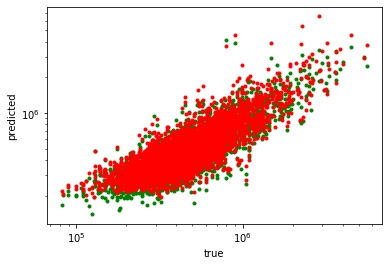

In [5]:
predict_msle = np.exp(msle_model.predict(dtest2))-1

label = dtest.get_label()

predict_mse = mse_model.predict(dtest)

abs_res_msle = np.abs(label-predict_msle)
abs_res_mse = np.abs(label-predict_mse)

pl.figure()
pl.plot(label, predict_msle, 'g.', label="msle")
pl.plot(label, predict_mse, 'r.', label="mse")
pl.xlabel('true')
pl.ylabel('predicted')
pl.yscale('log')
pl.xscale('log')

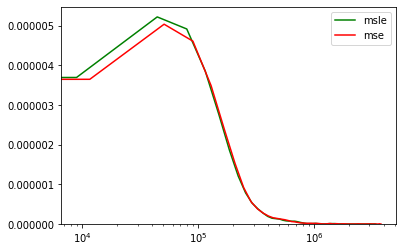

In [6]:
sns.distplot(abs_res_msle, hist=False, kde=True, color='green', label='msle')
sns.distplot(abs_res_mse, hist=False, kde=True, color='red', label='mse')
pl.xscale('log')


MSE seems to lead generally to smaller residuals. However, we expect MSLE to perform better on small residuals, while MSE should perform better on large residuals.

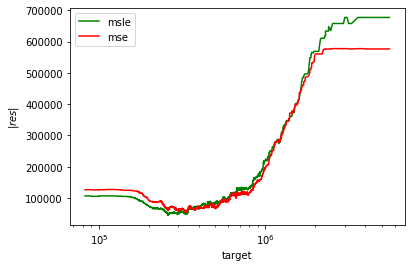

In [8]:
from scipy.ndimage.filters import gaussian_filter1d, median_filter

abs_res_msle_sorted = abs_res_msle[np.argsort(label)]
abs_res_mse_sorted = abs_res_mse[np.argsort(label)]
label_sorted = np.sort(label)

# use median filter to smooth residuals and see the trend.
pl.plot(label_sorted, median_filter(abs_res_msle_sorted,  size=200), 'g-', label='msle')
pl.plot(label_sorted, median_filter(abs_res_mse_sorted,  size=200), 'r-', label='mse')

pl.xscale('log')
pl.xlabel('target')
pl.ylabel(r'$\|res\|$')
pl.legend()

Horray!